# Low-Rank Approximation For Neural Network Optimization
This simple Notebook is the implementation and analysis for the paper titled "_Penerapan Singular Value Decomposition untuk Optimasi Neural Networks melalui Low-Rank Approximation_". The project explores the application of low-rank approximation using Singular Value Decomposition (SVD) to optimize neural networks, focusing on reducing memory usage and computation time while maintaining accuracy.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Sequential

# Set the random seed for TensorFlow
tf.keras.utils.set_random_seed(42)

# Load The Dataset  
MNIST dataset provides 70,000 images with a size of 28x28 pixels containing handwritten digits that have been labeled. The data used in the training process consists of 60,000 images, and the data used in the testing process consists of 10,000 images.

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize date
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten input (28x28 to 784)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# One-hot encoding for label
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [3]:
print("Train datas shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Train datas shape: (60000, 784)
Test data shape: (10000, 784)


## Exploratory Data Analysis

In this section, we will explore the MNIST dataset by visualizing some of the images and understanding the distribution of the data. This will help us gain insights into the dataset before proceeding with the modeling.

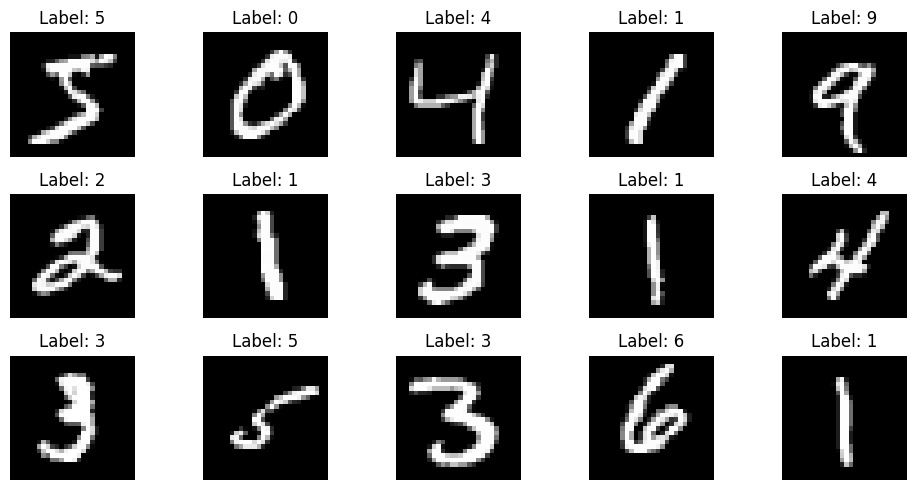

In [4]:
# Display a couple of images from the dataset in two rows
num_images = 15
fig, axes = plt.subplots(3, num_images // 3, figsize=(10, 5))
axes = axes.flatten()
for i in range(num_images):
    axes[i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Label: {np.argmax(y_train[i])}", fontsize=12)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

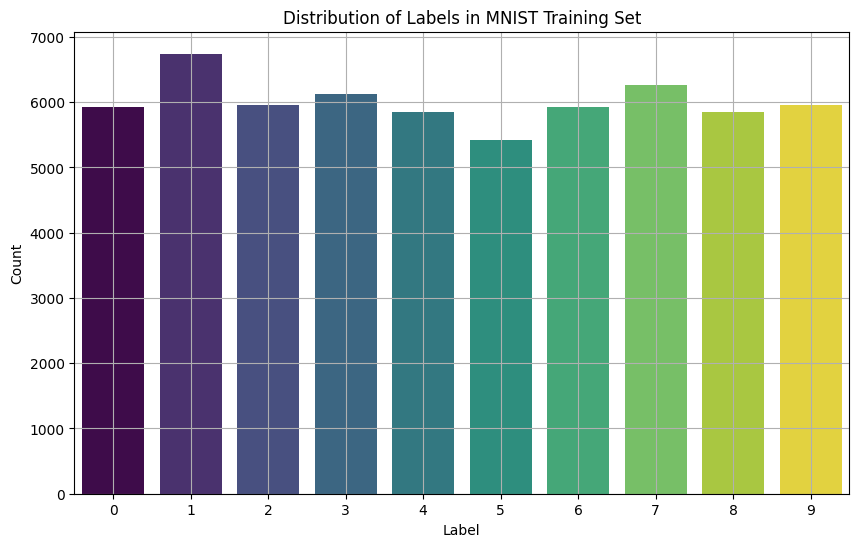

In [5]:
# Count the occurrences of each label in the training set
label_counts = np.argmax(y_train, axis=1)
label_counts = pd.Series(label_counts).value_counts().sort_index()

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis', dodge=False, legend=False)
plt.title('Distribution of Labels in MNIST Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(label_counts.index)
plt.grid(True)
plt.show()

# Modeling
In this section, we will define and train the original fully connected model using the MNIST dataset. We will also create a low-rank approximation of the model to reduce the number of parameters and improve inference time. 

### Original Model
Define the original model without low-rank approximation

In [6]:
# Define the original fully connected model

original_model = Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(1028, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="sigmoid")
])

original_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1028)           │       806,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,726 (5.60 MB)

 Trainable params: 1,467,726 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

### Train the original model
Compile and train the original model with 5 epochs and 0.2 validation split

In [7]:
# Compile and train the original model
original_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = original_model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8922 - loss: 0.3430 - val_accuracy: 0.9645 - val_loss: 0.1228
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9694 - loss: 0.1034 - val_accuracy: 0.9699 - val_loss: 0.1140
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9764 - loss: 0.0729 - val_accuracy: 0.9748 - val_loss: 0.1083
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9846 - loss: 0.0511 - val_accuracy: 0.9722 - val_loss: 0.1112
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9869 - loss: 0.0420 - val_accuracy: 0.9717 - val_loss: 0.1189


### Low-Rank Model
Create a low-rank approximation of the original fully connected model. This technique reduces the number of parameters in the model, which can lead to faster inference times and lower memory usage. We will define a function to apply low-rank approximation to the dense layers and then create a new model using this function.

In [8]:

def apply_low_rank_approximation(layer, rank):
    weights, biases = layer.get_weights()
    
    # Do SVD decomposition
    U, S, Vt = np.linalg.svd(weights, full_matrices=False)
    
    # make sure rank is not greater than the number of singular values
    rank = min(rank, len(S))
    
    # choose r singular values
    U_r = U[:, :rank]
    S_r = np.diag(S[:rank])
    Vt_r = Vt[:rank, :]

    # replace one dense layer with two new dense layers
    dense1 = layers.Dense(rank, activation=None, use_bias=False)
    dense2 = layers.Dense(layer.units, activation=layer.activation, use_bias=True)

    return [dense1, dense2], [U_r @ S_r, Vt_r, biases]


In [9]:
# Create a low-rank model
def create_low_rank_model(original_model, rank):
    low_rank_model = tf.keras.Sequential()
    low_rank_model.add(layers.Input(shape=(784,)))

    for layer in original_model.layers:

        # For simplicity, apply low-rank approximation only to Dense layers
        if isinstance(layer, tf.keras.layers.Dense):
            new_layers, new_weights = apply_low_rank_approximation(layer=layer, rank=rank)

            # add new layers to the model
            for new_layer in new_layers:
                low_rank_model.add(new_layer)
            
            # set the weights of the new layers
            low_rank_model.layers[-2].set_weights([new_weights[0]])
            low_rank_model.layers[-1].set_weights([new_weights[1], new_weights[2]])

        else:
            low_rank_model.add(layer)

    return low_rank_model

### Create The Low-Rank Model
View the architecture of the optimized model

In [10]:
# Choose a rank
rank = 25
low_rank_model = create_low_rank_model(original_model, rank)

low_rank_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 25)             │        19,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1028)           │        26,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,466 (419.79 KB)

 Trainable params: 107,466 (419.79 KB)

 Non-trainable params: 0 (0.00 B)

# Evaluation
In this section, we will evaluate the performance of both the original and low-rank models. We will compare their accuracy, inference time, and the number of parameters to understand the trade-offs between model complexity and performance.

In [11]:
def measure_inference_time(model, dataset, iterations=10):
    import time
    start_time = time.time()
    for _ in range(iterations):
        _ = model.predict(dataset, verbose=0)
    end_time = time.time()
    return (end_time - start_time) / iterations

### Compare
Compare the performance of the original model with the low-rank model using various chosen ranks.

In [12]:
time_arr = []
acc_arr = []
total_params = []

# Original model
print("Original Model:")

acc = original_model.evaluate(x_test, y_test)[1]
acc_arr.append(acc)
print("Accuracy:", acc)

time_eff = measure_inference_time(original_model, x_test)
time_arr.append(time_eff)
print("Time efficiency:", time_eff)

total_params.append(original_model.count_params())
print("Total params:", original_model.count_params())

# Low-rank model
rank = [1, 5, 10, 15, 20, 25, 50, 100]
for r in rank:
    print()
    print(f"Low-Rank Model with rank {r}:")
    low_rank_model = create_low_rank_model(original_model, r)
    low_rank_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    acc = low_rank_model.evaluate(x_test, y_test)[1]
    acc_arr.append(acc)
    print("Accuracy:", acc)

    time_eff_r = measure_inference_time(low_rank_model, x_test)
    time_arr.append(time_eff_r)
    print("Time efficiency:", time_eff_r)
    
    total_params.append(low_rank_model.count_params())
    print("Total params:", low_rank_model.count_params())

Original Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9679 - loss: 0.1416
Accuracy: 0.9726999998092651
Time efficiency: 0.935923433303833
Total params: 1467726

Low-Rank Model with rank 1:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0941 - loss: 2.3101
Accuracy: 0.09740000218153
Time efficiency: 0.5686225652694702
Total params: 6192

Low-Rank Model with rank 5:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2051 - loss: 2.0841
Accuracy: 0.21539999544620514
Time efficiency: 0.5866824388504028
Total params: 23736

Low-Rank Model with rank 10:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6664 - loss: 1.8194
Accuracy: 0.6887999773025513
Time efficiency: 0.5849722862243653
Total params: 45666

Low-Rank Model with rank 15:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8464 - loss: 0.5242
Accuracy: 0.8707000017166138
Time efficiency: 0.5978488445281982
Total params: 66266

Low-Rank Model with rank 20:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

In [13]:
speedup = [f"{(time_arr[0] / t):.2f}x" for t in time_arr]
memory = [f"{(p*4 / 1024 / 1024):.2f} MB" for p in total_params]
memory_saving = [f"{(100 - p / total_params[0] * 100):.2f}%" for p in total_params]

result = pd.DataFrame({
    "Rank": ["Original"] + rank,
    "Accuracy": acc_arr,
    "Time Efficiency": time_arr,
    "Speedup": speedup,
    "Total Parameters": total_params,
    "Memory": memory,
    "Memory Saving": memory_saving
})
result = result.set_index("Rank")
result


,Accuracy,Time Efficiency,Speedup,Total Parameters,Memory,Memory Saving
Rank,,,,,,
Original,0.9727,0.935923,1.00x,1467726,5.60 MB,0.00%
1,0.0974,0.568623,1.65x,6192,0.02 MB,99.58%
5,0.2154,0.586682,1.60x,23736,0.09 MB,98.38%
10,0.6888,0.584972,1.60x,45666,0.17 MB,96.89%
15,0.8707,0.597849,1.57x,66266,0.25 MB,95.49%
20,0.9502,0.616083,1.52x,86866,0.33 MB,94.08%
25,0.9651,0.618620,1.51x,107466,0.41 MB,92.68%
50,0.9710,0.675543,1.39x,210466,0.80 MB,85.66%
100,0.9716,0.790050,1.18x,416466,1.59 MB,71.63%



### Visualization of Results

Visualize the results of our experiments. We will plot the accuracy, time efficiency, and total parameters of the original model and the low-rank models with different ranks. This will help us understand the trade-offs between model complexity and performance.

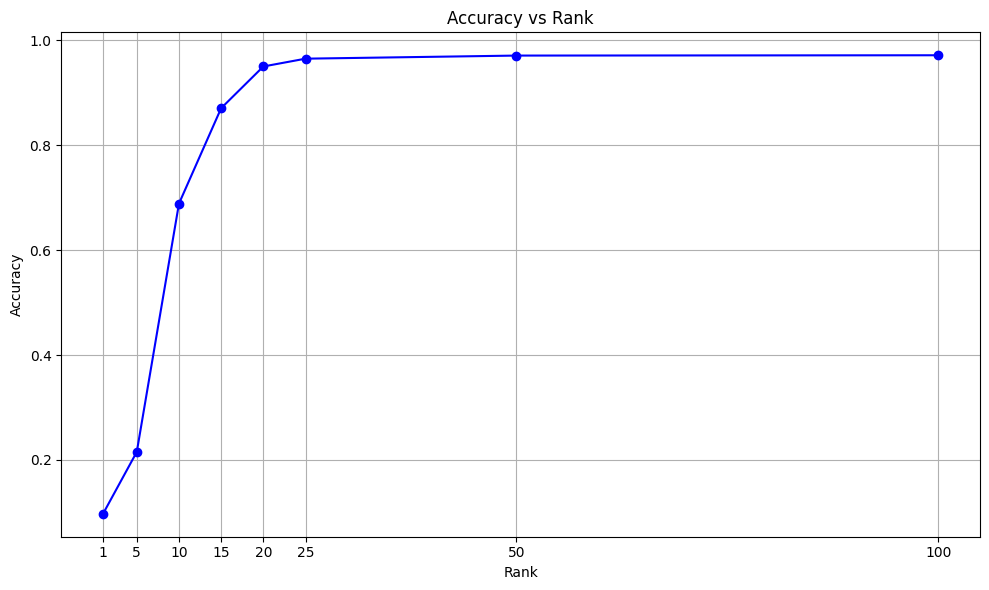

In [17]:
accuracies = acc_arr[1:] 

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(rank, accuracies, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Accuracy vs Rank')
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rank)
plt.tight_layout()

# Show the plot
plt.show()

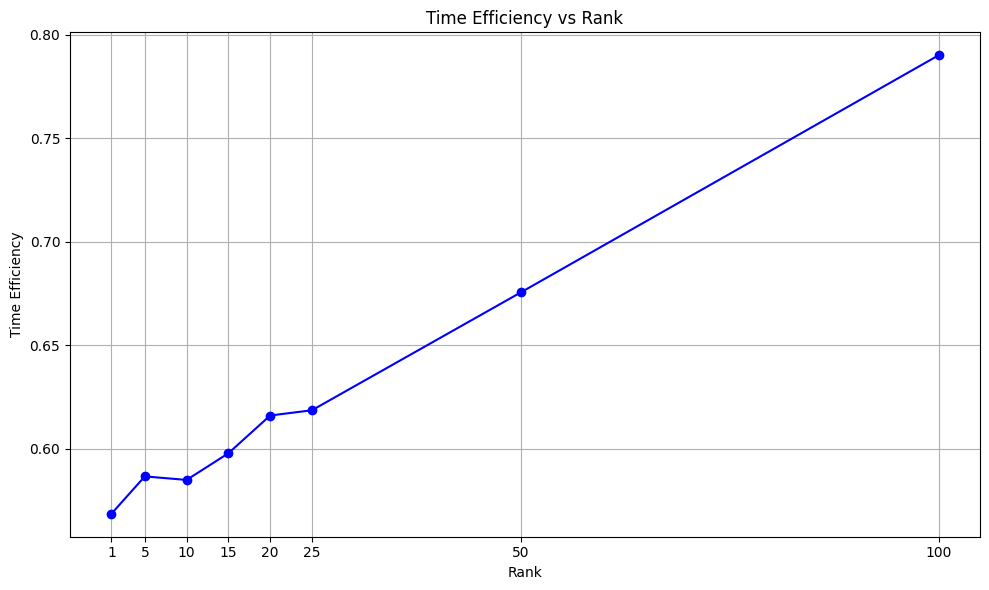

In [18]:
times = time_arr[1:] 

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(rank, times, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Time Efficiency vs Rank')
plt.xlabel('Rank')
plt.ylabel('Time Efficiency')
plt.grid(True)
plt.xticks(rank)
plt.tight_layout()

# Show the plot
plt.show()

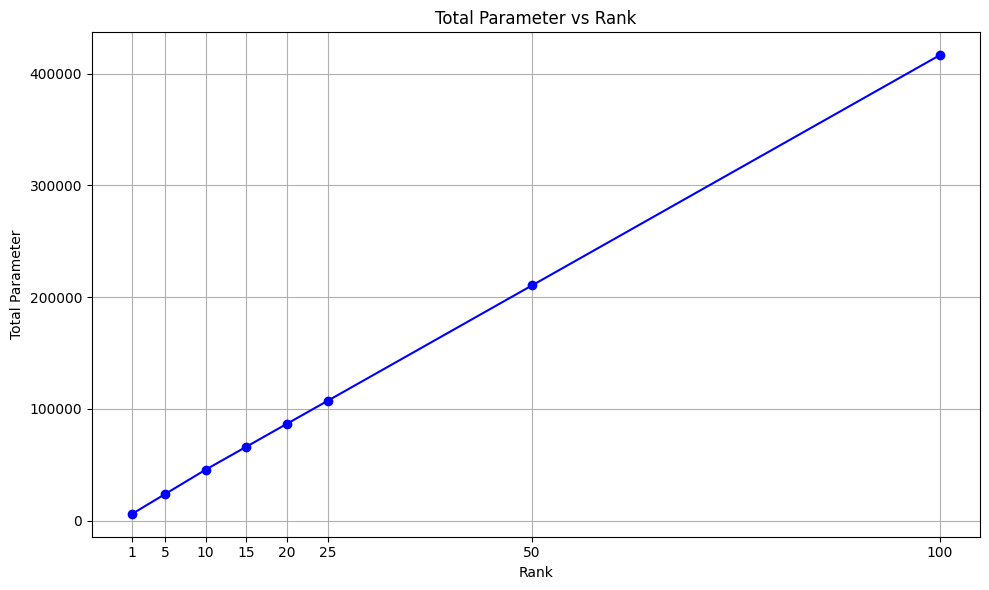

In [19]:
params = total_params[1:]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(rank, params, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Parameter vs Rank')
plt.xlabel('Rank')
plt.ylabel('Total Parameter')
plt.grid(True)
plt.xticks(rank)
plt.tight_layout()

# Show the plot
plt.show()